# Logistic Growth Fitting

In [1]:
import numpy as np
import random
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(palette='husl')

In [2]:
# Logistic growth model
def logistic(x, r, k, x_0):
    f = k / (1 + np.exp(-r * (x - x_0)))
    return f

In [3]:
def log_logistic(x, r, k, x_0):
    f = np.log(logistic(x, r, k, x_0))
    return f

In [4]:
# Estimate growth rate by finding maximum symmetric difference (slope)
def find_r(data):
    max_diff = 0
    for i in range(1, len(data) - 1):
        diff = (data[i + 1] - data[i - 1]) * 6
        if(diff > max_diff):
            max_diff = diff
    return max_diff

In [5]:
# Finds closest value in a list to a target value (closest OD to likely sigmoid midpoint)
def find_x_0(times, data, n):
    sig_mid = np.max(times)
    sig_mid_val = np.max(data)
    for i in range(len(times)):
        if(np.abs(data[i] - n) < sig_mid_val):
            sig_mid_val = np.abs(data[i] - n)
            sig_mid = times[i]
    return sig_mid

In [6]:
# Read in culture data, filtering out MYPL columns from Excel
strain_mrs_cols = [1]
for i in range(0, 72, 12):
    for j in range (6):
        strain_mrs_cols.append(j + i + 3)
strain_data = pd.read_excel('C:/Users/bubba/OneDrive/Desktop/School/Ludington Lab/6_species_gc_2_15.xlsx', usecols=strain_mrs_cols, index_col=0, header=0, skiprows=range(57), nrows=577)
strain_data

# Read in control MRS media data
blank_mrs_cols = [1]
for i in range(72, 96, 12):
    for j in range (6):
        blank_mrs_cols.append(j + i + 3)

media_data = pd.read_excel('C:/Users/bubba/OneDrive/Desktop/School/Ludington Lab/6_species_gc_2_15.xlsx', usecols=blank_mrs_cols, index_col=0, header=0, skiprows=range(57), nrows=577)
media_data

,G1,G2,G3,G4,G5,G6,H1,H2,H3,H4,H5,H6
Time,,,,,,,,,,,,
00:04:16,0.177,0.198,0.184,0.182,0.171,0.192,0.180,0.370,0.406,0.336,0.180,0.184
00:09:16,0.177,0.198,0.184,0.182,0.172,0.192,0.180,0.370,0.405,0.333,0.180,0.184
00:14:16,0.177,0.198,0.185,0.182,0.173,0.192,0.181,0.370,0.405,0.331,0.181,0.184
00:19:16,0.178,0.199,0.185,0.183,0.174,0.193,0.182,0.370,0.405,0.328,0.182,0.185
00:24:16,0.179,0.200,0.186,0.184,0.175,0.194,0.183,0.371,0.405,0.327,0.183,0.186
...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 23:44:16,0.206,0.228,0.219,0.223,0.195,0.211,0.217,0.215,0.213,0.184,0.200,0.197
1900-01-01 23:49:16,0.206,0.228,0.219,0.223,0.194,0.211,0.217,0.215,0.213,0.183,0.200,0.197
1900-01-01 23:54:16,0.206,0.228,0.219,0.223,0.194,0.211,0.217,0.215,0.213,0.183,0.200,0.197


In [7]:
# Normalize data by subtracting media readings out (average reading for each timepoint to account for evaporation etc)
norm_factors = media_data.mean(axis=1).to_frame()
for i in range(1, len(strain_data.columns)):
    norm_factors[i] = norm_factors.loc[:, 0]
strain_data = np.subtract(strain_data, np.asarray(norm_factors))
# Adjust any negative values to 0
strain_data[strain_data < 0] = 0
strain_data

,A1,A2,A3,A4,A5,A6,B1,B2,B3,B4,...,E3,E4,E5,E6,F1,F2,F3,F4,F5,F6
Time,,,,,,,,,,,,,,,,,,,,,
00:04:16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00:09:16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00:14:16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00:19:16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00:24:16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 23:44:16,1.643000,1.591000,1.597000,1.589000,1.549000,1.594000,1.629000,1.612000,1.609000,1.603000,...,0.561000,0.514000,0.549000,0.572000,1.334000,1.318000,1.360000,1.109000,1.329000,1.329000
1900-01-01 23:49:16,1.642167,1.592167,1.597167,1.589167,1.549167,1.594167,1.630167,1.612167,1.609167,1.604167,...,0.561167,0.513167,0.548167,0.572167,1.330167,1.317167,1.359167,1.112167,1.331167,1.331167
1900-01-01 23:54:16,1.644167,1.593167,1.598167,1.591167,1.550167,1.595167,1.624167,1.612167,1.608167,1.603167,...,0.562167,0.512167,0.548167,0.571167,1.334167,1.317167,1.362167,1.112167,1.330167,1.330167


R values: 
{'A1': 0.6321946267907907, 'A2': 0.6691128118608762, 'A3': 0.6461968736489005, 'A4': 0.6563982960408226, 'A5': 0.6630187862013676, 'A6': 0.6494694135070382, 'B1': 0.28325892085417936, 'B2': 0.28121042808810676, 'B3': 0.2711576730663088, 'B4': 0.26384599106044976, 'B5': 0.2825491250081289, 'B6': 0.25458602618365944, 'C1': 0.18509722911280121, 'C2': 0.15127496279235034, 'C3': 0.22663956774214267, 'C4': 0.1923163928435661, 'C5': 0.20166123748269774, 'C6': 0.18891305459452998, 'D1': 0.24145040186633965, 'D2': 0.22782243801781824, 'D3': 0.2606828420611651, 'D4': 0.30686977157093065, 'D5': 0.26186024388801665, 'D6': 0.28113155522148064, 'E1': 0.37916995545340904, 'E2': 0.37517243168177644, 'E3': 0.21387205982554378, 'E4': 0.4075547435756806, 'E5': 0.3152334596110703, 'E6': 0.4206863510280014, 'F1': 0.19307689844898646, 'F2': 0.19041444875507468, 'F3': 0.19570296948843652, 'F4': 0.2527364146040449, 'F5': 0.20272639748901225, 'F6': 0.2059620423952263}
K values: 
{'A1': 1.57765102272

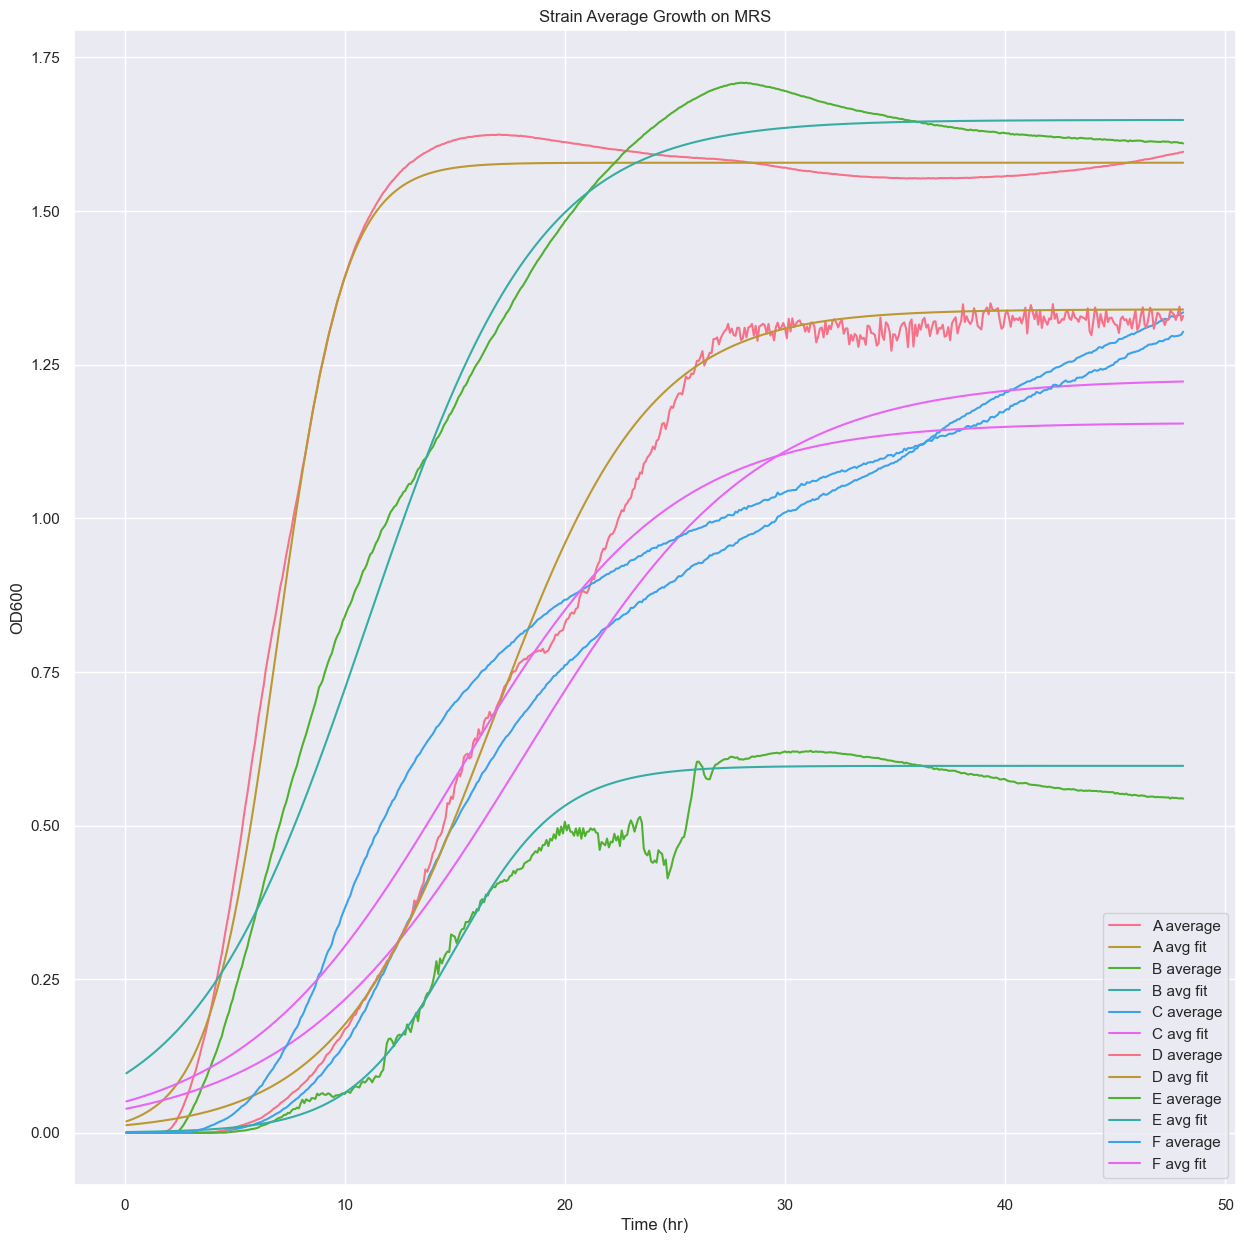

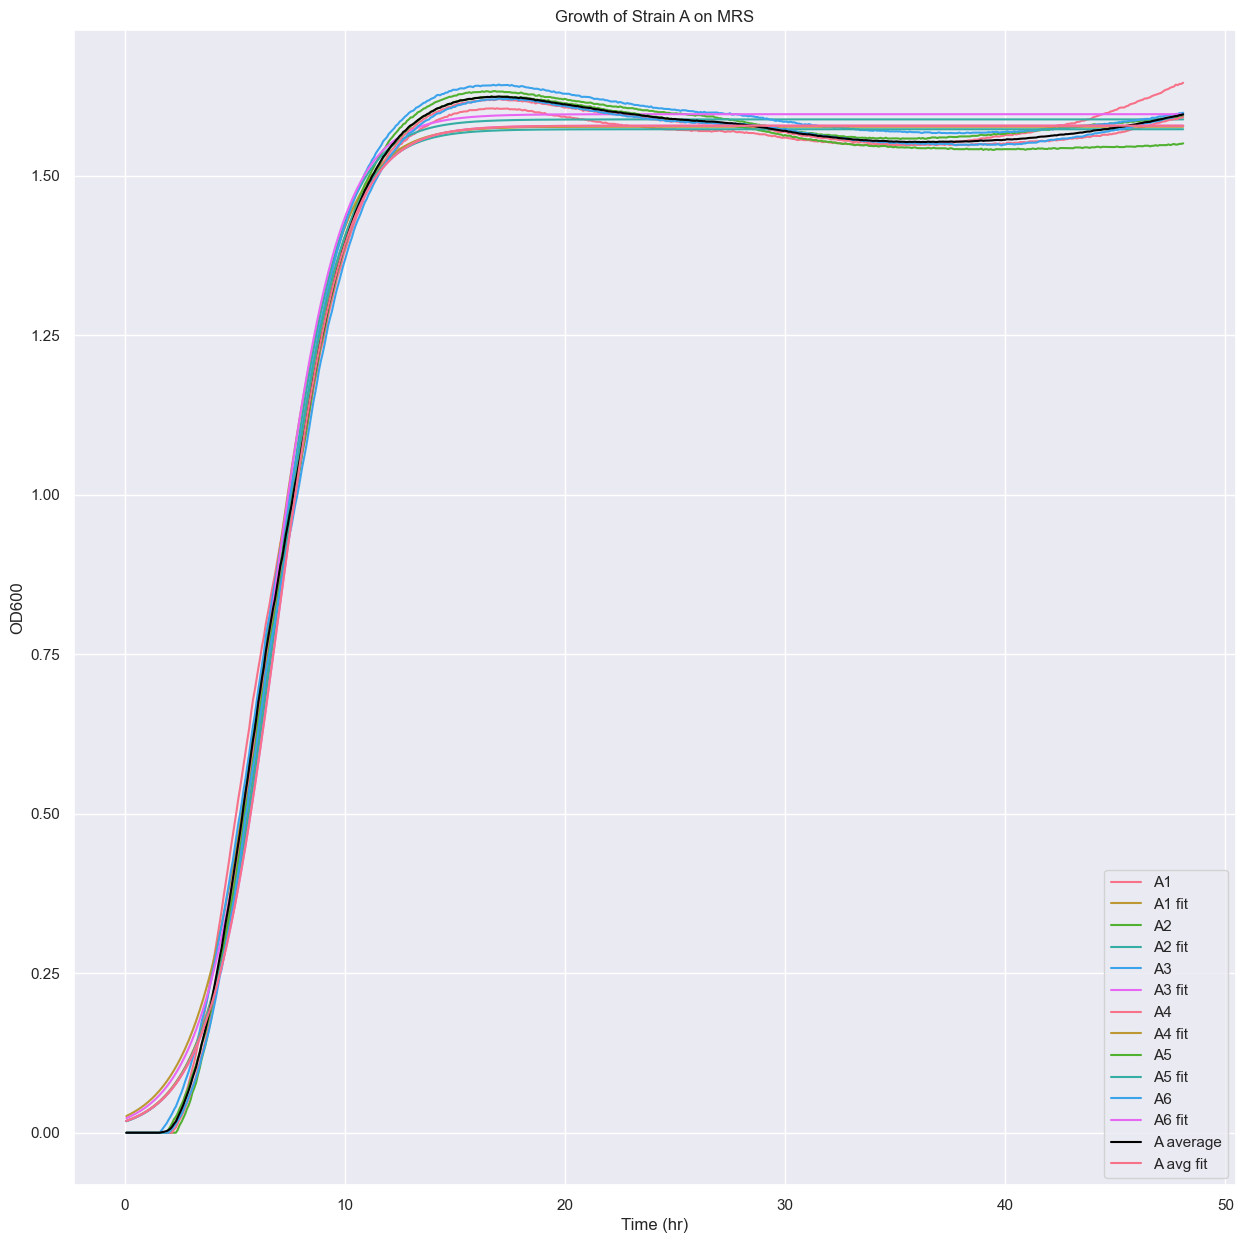

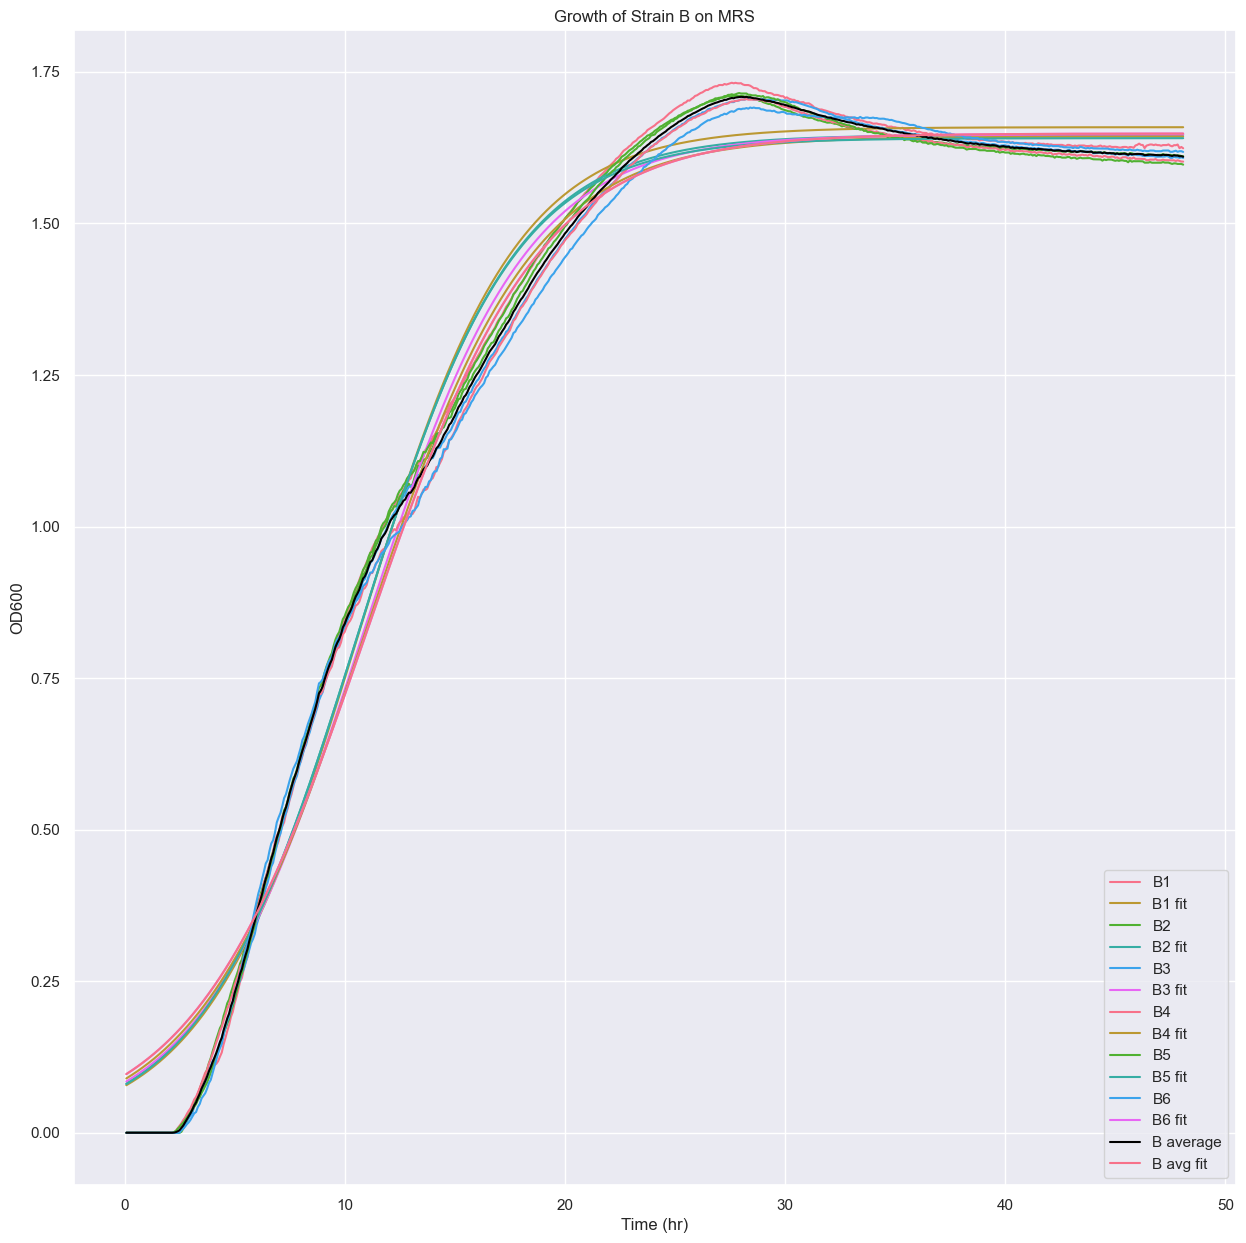

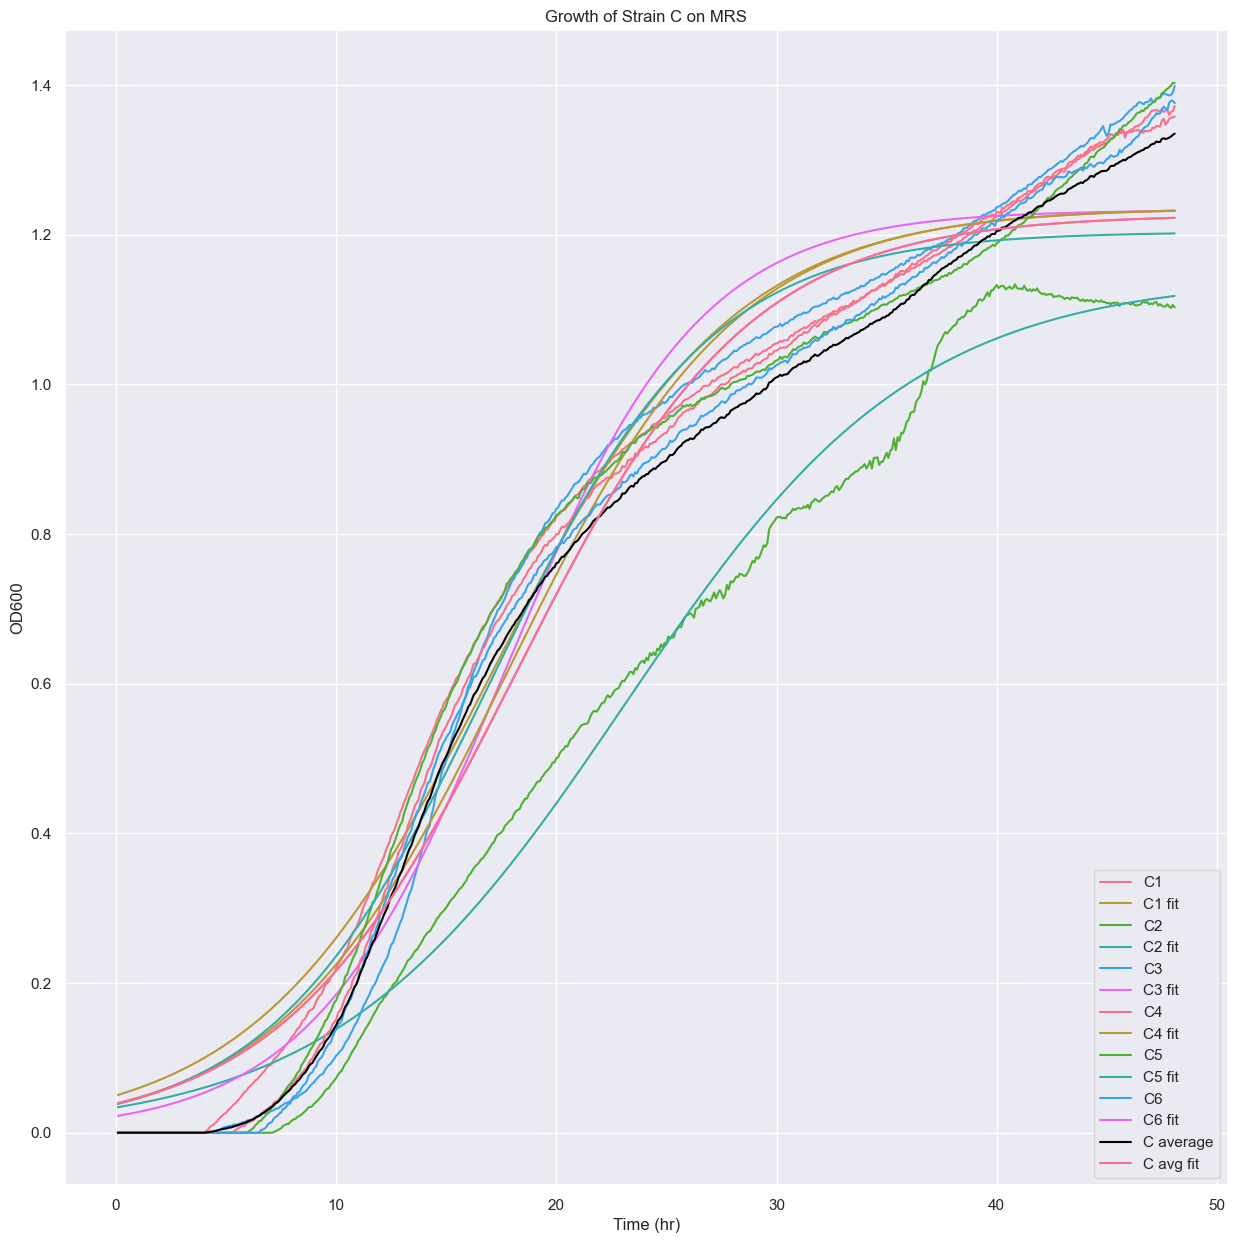

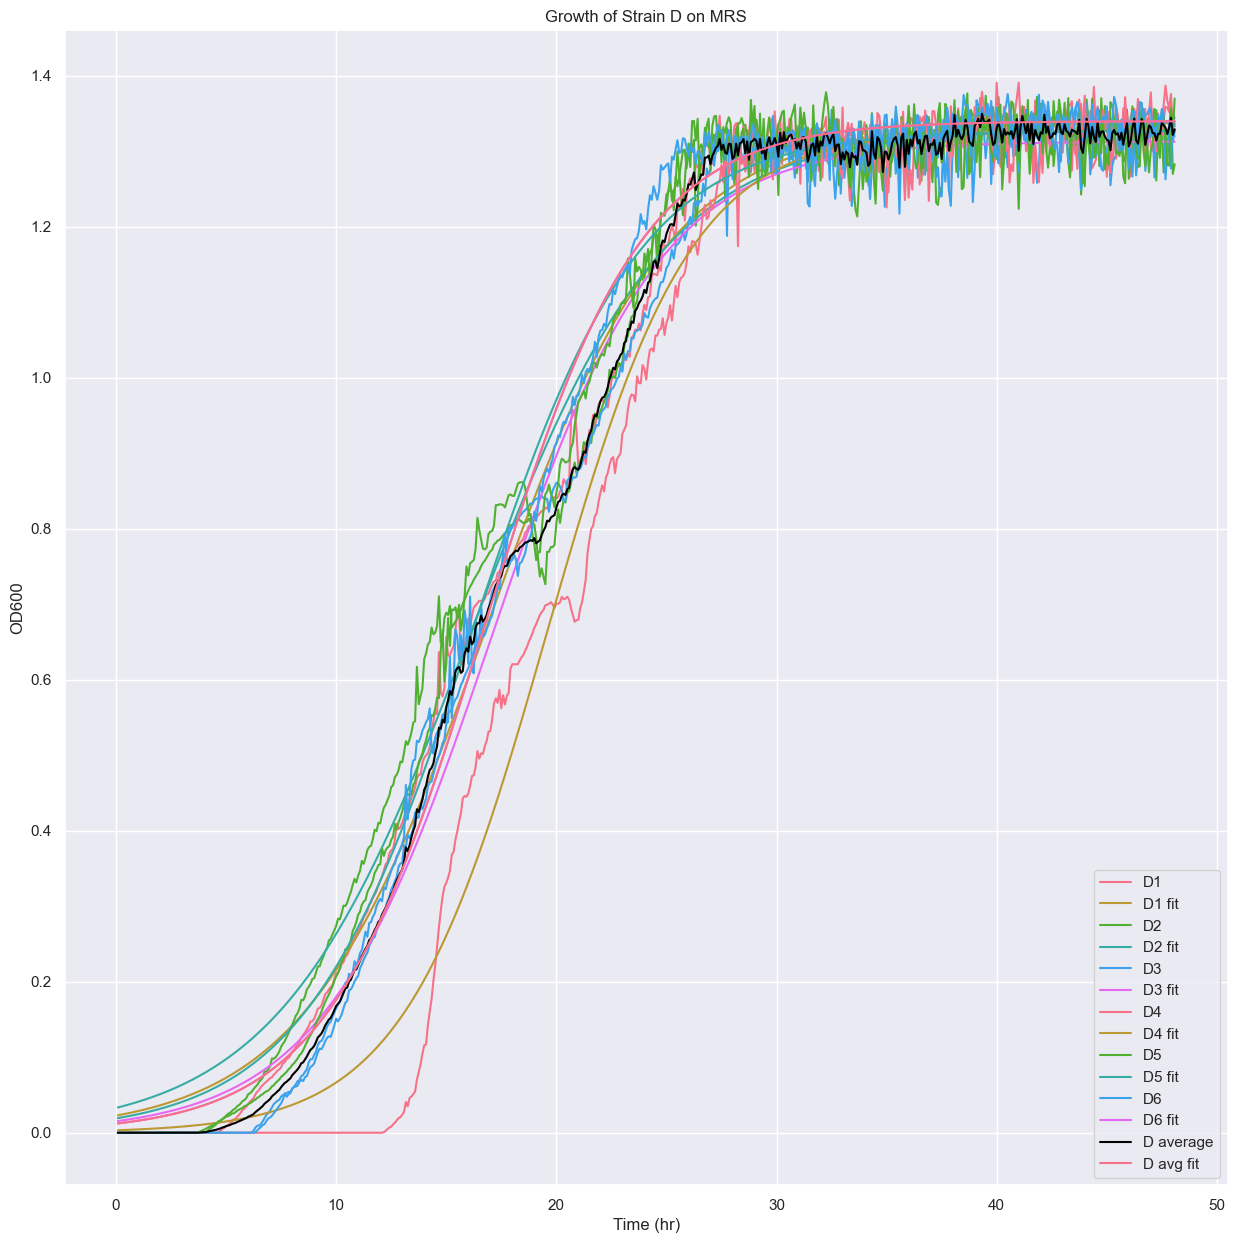

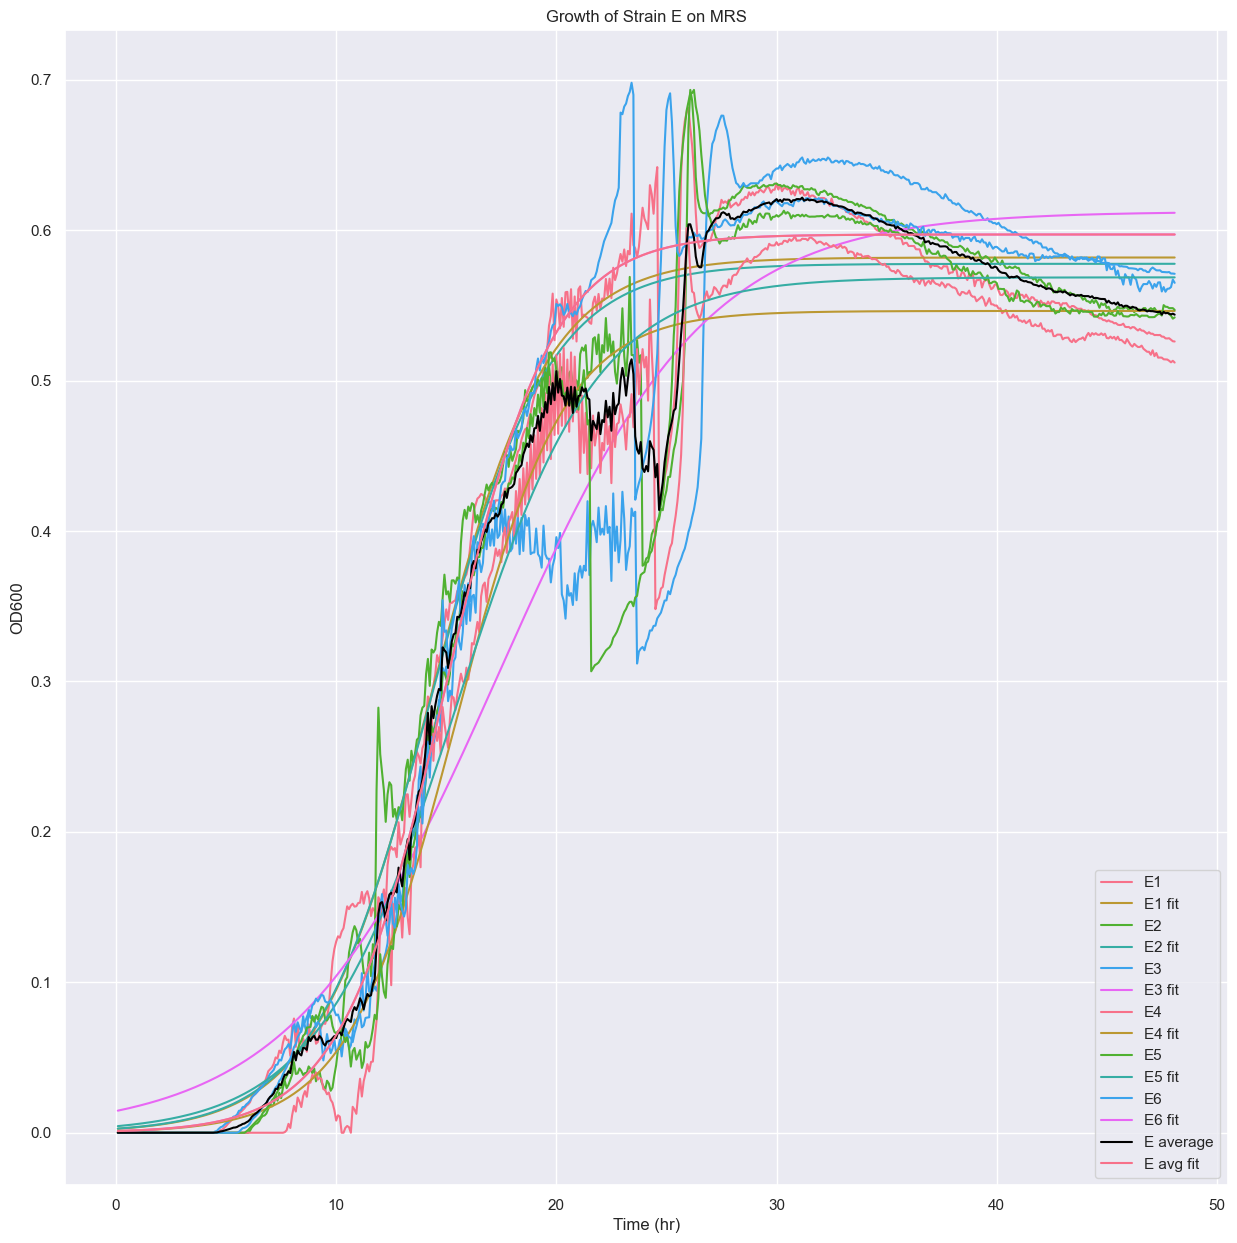

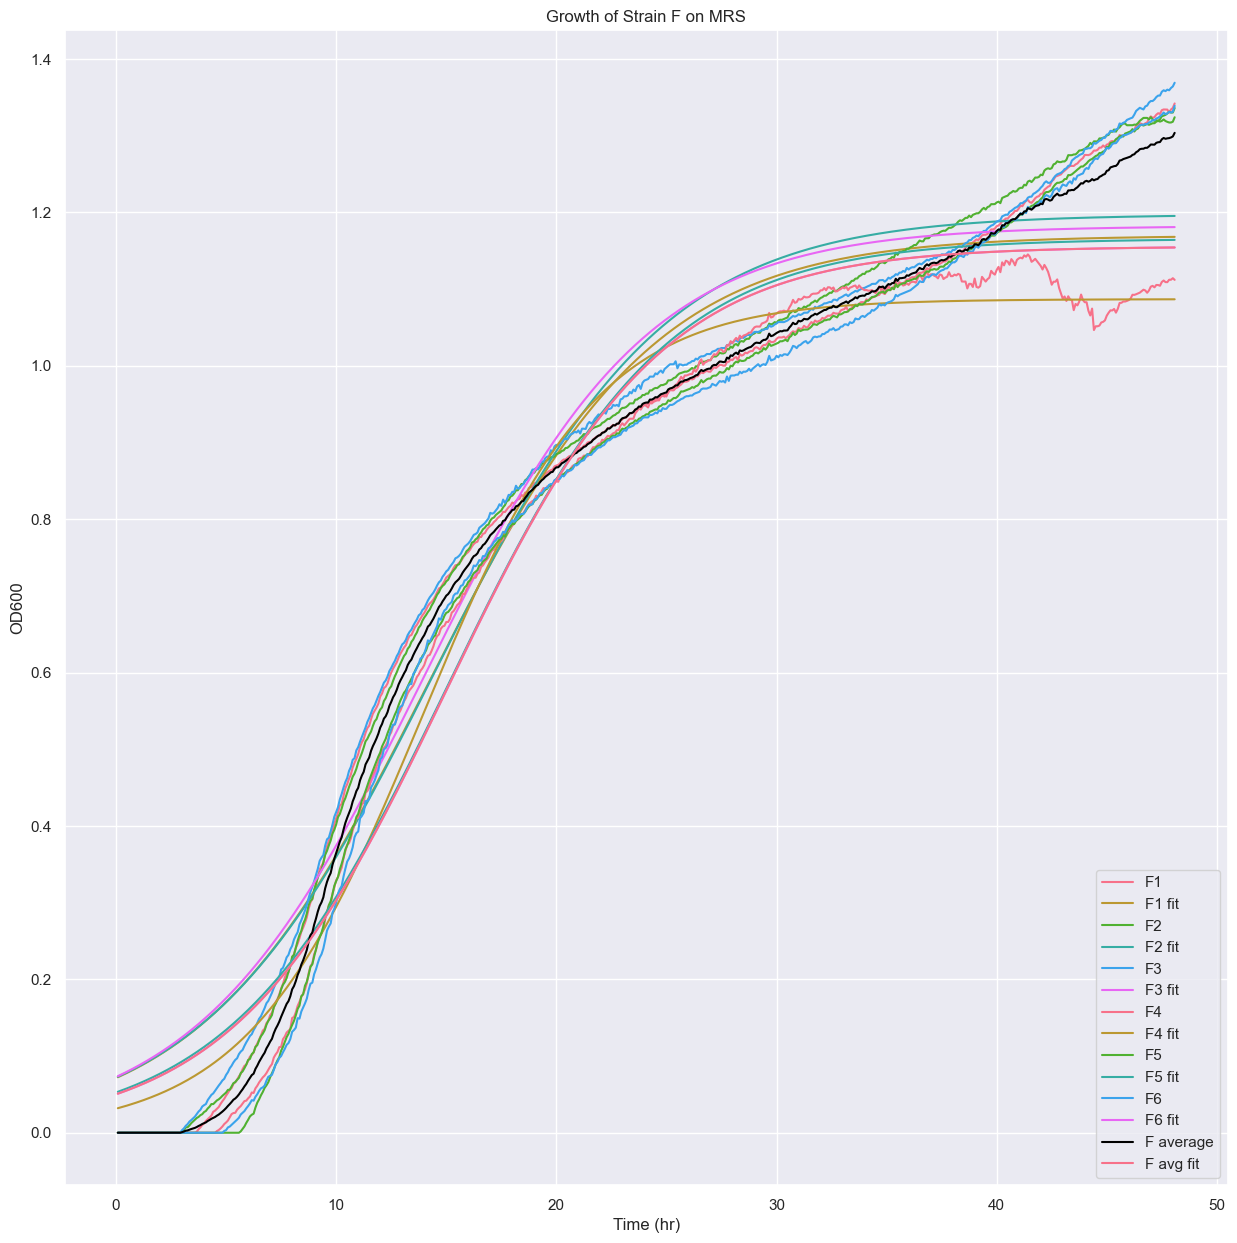

In [8]:
strains = ['A', 'B', 'C', 'D', 'E', 'F']
r_vals = {}
k_vals = {}
x_0_vals = {}
indiv_strain_dfs = {}

# Time range of 48 hours, cut into 5 minute timepoints
x_vals = np.arange(5 / 60, 48 + (1 / 6), 5 / 60)

# Summary plot
fig, avg_ax = plt.subplots(1,1,figsize=(15,15), sharex=True, sharey=True)

# For each main strain
for strain in strains:
    
    # Isolate a single dataframe corresponding to the strain
    i = 6 * strains.index(strain)
    single_strain = strain_data.iloc[:, i:(i + 6)]
    
    # Plot for single strain
    fig, strain_ax = plt.subplots(1,1,figsize=(15,15), sharex=True, sharey=True)
    
    # For each replicate
    for i in single_strain:
        
        # Make parameter estimates
        k_guess = single_strain[i].max()
        r_guess = find_r(single_strain[i].values)
        x_0_guess = find_x_0(x_vals, single_strain[i].values, 0.1)
        
        # Implement curve fitting
        try:
            est_func, pcov = curve_fit(logistic, x_vals, single_strain[i].values, p0=[1, k_guess, x_0_guess])
        except RuntimeError:
            pass
        
        # Record fitted parameters
        r_vals[i] = est_func[0]
        k_vals[i] = est_func[1]
        x_0_vals[i] = est_func[2]
        
        # Obtain fitted data
        est_curve = logistic(x_vals, *est_func)
        
        # Plot replicate and fit data onto strain plot
        strain_ax.plot(x_vals, single_strain[i].values, label=i)
        strain_ax.plot(x_vals, est_curve, label=i+' fit')
    
    # Find the average of the replicates
    rep_avg = single_strain.mean(axis=1)
    
    # Same fitting + plotting as above for average
    try:
        avg_func, pcov = curve_fit(logistic, x_vals, rep_avg, p0=[r_guess, k_guess, x_0_guess])
    except RuntimeError:
        pass
    avg_curve = logistic(x_vals, *est_func)
    strain_ax.plot(x_vals, rep_avg, 'k', label=strain+' average')
    strain_ax.plot(x_vals, avg_curve, label=strain+' avg fit')
    
    # Strain plot details
    strain_ax.legend(loc='lower right')
    strain_ax.set_xlabel("Time (hr)")
    strain_ax.set_ylabel("OD600")
    strain_ax.set(title='Growth of Strain ' + strain + ' on MRS')
    
    # Plot average onto summary plot
    avg_ax.plot(x_vals, rep_avg, label=strain+' average')
    avg_ax.plot(x_vals, avg_curve, label=strain+' avg fit')
    
# Summary plot details
avg_ax.set_xlabel("Time (hr)")
avg_ax.set_ylabel("OD600")
avg_ax.set(title='Strain Average Growth on MRS')
avg_ax.legend(loc='lower right')

# Display collected parameters
print('R values: ')
print(r_vals)
print('K values: ')
print(k_vals)
print('Sigmoid midpoint values: ')
print(x_0_vals)